## STTMALST Gastrointestinal-Cancer-MSI-MSS-Prediction TRANSFER LEARNING ATTEMPT 

This notebook tries to attempt what did not work when trying to create a CNN with such a large dataset running on a single computer.<br> 
Here the entire notebook will be heavily inspired by: https://www.tensorflow.org/tutorials/images/transfer_learning, which explains how to <br>
use transfer learning to create a base model from the ModelNet V2 created by google. Here we will explore if transfer learning proves to be a better <br>
alternative to a CNN which took over 7 hours to run. Some items in this notebook reuses code from the CNN notebook. 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib 

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib

In [14]:
#GLOBAL VALUES
batch_size = 32
img_size = (224,224)
epochs = 5

In [15]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())

Tensorflow version:  2.5.0-dev20201217
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6097443973775565582
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5845129625
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2942137871238134387
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [16]:
DATA_PATH = './tcga_coad_msi_mss'
data_dir = pathlib.Path(DATA_PATH)

training_set_dir = os.path.join(DATA_PATH, 'train')
training_root = pathlib.Path(training_set_dir)

test_set_dir = os.path.join(DATA_PATH, 'test')
test_root = pathlib.Path(test_set_dir)

validation_set_dir = os.path.join(DATA_PATH,'val')
validation_root = pathlib.Path(validation_set_dir)

In [18]:
#Train dataset
train_ds = image_dataset_from_directory(training_root,
 seed=222,
  image_size=img_size,
   batch_size=batch_size,
    shuffle=True)

#Test dataset
test_ds = image_dataset_from_directory(test_root,
 seed=222,
  image_size=img_size,
   batch_size=batch_size,
    shuffle=True)

#Validation dataset
val_ds = image_dataset_from_directory(validation_root,
 seed=222,
  image_size=img_size,
   batch_size=batch_size,
    shuffle=True)

Found 153849 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.
Found 19230 files belonging to 2 classes.


In [21]:
class_names = train_ds.class_names
print(class_names)

['MSIMUT', 'MSS']


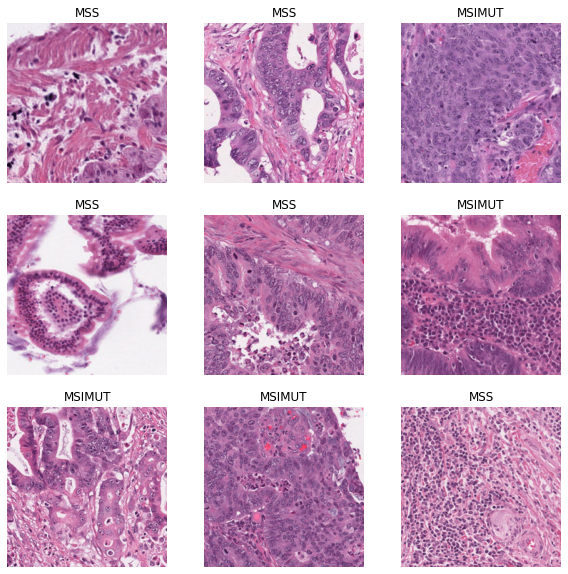

In [23]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 4808
Number of validation batches: 601
Number of test batches: 602


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

image_batch_numpy = image_batch.numpy()
labels_batch_numpy = labels_batch.numpy()
print('Training data: Minimum RGB value for batch: %.3f, Maximum RGB value: %.3f' % (image_batch_numpy.min(), image_batch_numpy.max()))

(32, 224, 224, 3)
(32,)
Training data: Minimum RGB value for batch: 0.000, Maximum RGB value: 255.000


## Introducing the _MobileNetV2_ base model

In [ ]:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input